# Set Required Args to Activate Modules

In [4]:
import RES.RESources as RES

In [5]:


# Iterate over provinces for both solar and wind resources
resource_types = ['wind','solar']  #
provinces=['BC']  #,'AB','SK','ON','NS','MB'
for province_code in provinces:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config.yaml',
            "province_short_code": province_code,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        # RES_module.build(select_top_sites=True,
        #                  use_pypsa_buses=False)
        

2025-06-11 10:06:40,539 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


____________________________________________________________
     Initiating RESource Builder...
____________________________________________________________
 └> NREL_ATBProcessor initiated...
  └> Processing Annual Technology Baseline (ATB) data sourced from NREL...
  └> ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'


2025-06-11 10:06:41,056 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


 └> Snapshot for Resources: 2023-01-01 07:00:00 to 2024-01-01 06:00:00
____________________________________________________________
     Initiating RESource Builder...
____________________________________________________________
 └> NREL_ATBProcessor initiated...
  └> Processing Annual Technology Baseline (ATB) data sourced from NREL...
  └> ATB cost datafile: ATBe.parquet loaded
  └> Extracting technology baseline costs...
  └─> Extracting Solar PV technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/solar'
  └─> Extracting Wind Turbine technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/wind'
  └─> Extracting BESS technology cost...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_BC.h5 with key 'cost/atb/bess'
 └> Snapshot for Resources: 2023-01-01 07:00:00 to 2024-01-01 06:00:00


# Playground for Top Site Selection

In [6]:
from RES.hdf5_handler import DataHandler
store="data/store/resources_BC.h5"
datahandler=DataHandler(store)

In [7]:
cells=datahandler.from_store('cells')
boundary=datahandler.from_store('boundary')
solar_clusters=datahandler.from_store('clusters/solar')
wind_clusters=datahandler.from_store('clusters/wind')
solar_clusters_ts=datahandler.from_store('timeseries/clusters/solar')
wind_clusters_ts=datahandler.from_store('timeseries/clusters/wind')

In [8]:
# wind_clusters[wind_clusters['lcoe']<=100].explore('potential_capacity')

In [23]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_wind=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=50)

>>> Selecting TOP Sites to for 10 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Okanagan-Similkameen_1) originally had 4.02 GW potential capacity.To fit the maximum capacity investment of 10 GW, it has been adjusted to 0.52 GW

>>> Selecting TOP Sites to for 50 GW Capacity Investment in BC...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 50 GW PV in BC
____________________________________________________________________________________________________

!! Note: The Last cluster (Thompson-Nicola_1) originally had 10.05 GW potential capacity.To fit the maximum capacity investment of 50 GW, it has been adjusted to 1.04 GW

In [24]:
RES_module.export_results('wind',
                    resource_clusters_wind,
                    cluster_timeseries_wind,)

wind clusters exported to :results


In [25]:
RES_module.export_results('solar',
                    resource_clusters_solar,
                    cluster_timeseries_solar,)

solar clusters exported to :results


In [26]:
resource_clusters_wind

,geometry,lcoe,capex,fom,vom,CF_mean,Cluster_No,potential_capacity,Region,nearest_station,nearest_station_distance_km,Rank,Operational_life,resource_type
cluster_id,,,,,,,,,,,,,,
PeaceRiver_1,"MULTIPOLYGON (((-122.18 55.1155, -122.17543 55...",36.291644,1.564557,0.0,0.0404,0.369432,1,47421.956644,PeaceRiver,BC_MNK_ISS,48.646353,1,20,wind
CentralOkanagan_1,"POLYGON ((-120.0419 49.8774, -120.0347 49.885,...",39.944596,1.564557,0.0,0.0404,0.326853,1,1541.173151,CentralOkanagan,BC_WWD_DSS,33.594975,2,20,wind
Thompson-Nicola_1,"MULTIPOLYGON (((-121.125 49.6106, -121.1246 49...",45.380986,1.564557,0.0,0.0404,0.295924,1,1036.870205,Thompson-Nicola,BC_VLM_DSS,53.189054,3,20,wind


In [27]:
# resource_clusters_solar.plot('potential_capacity',legend=True)
# resource_clusters_wind.plot('potential_capacity',legend=True)

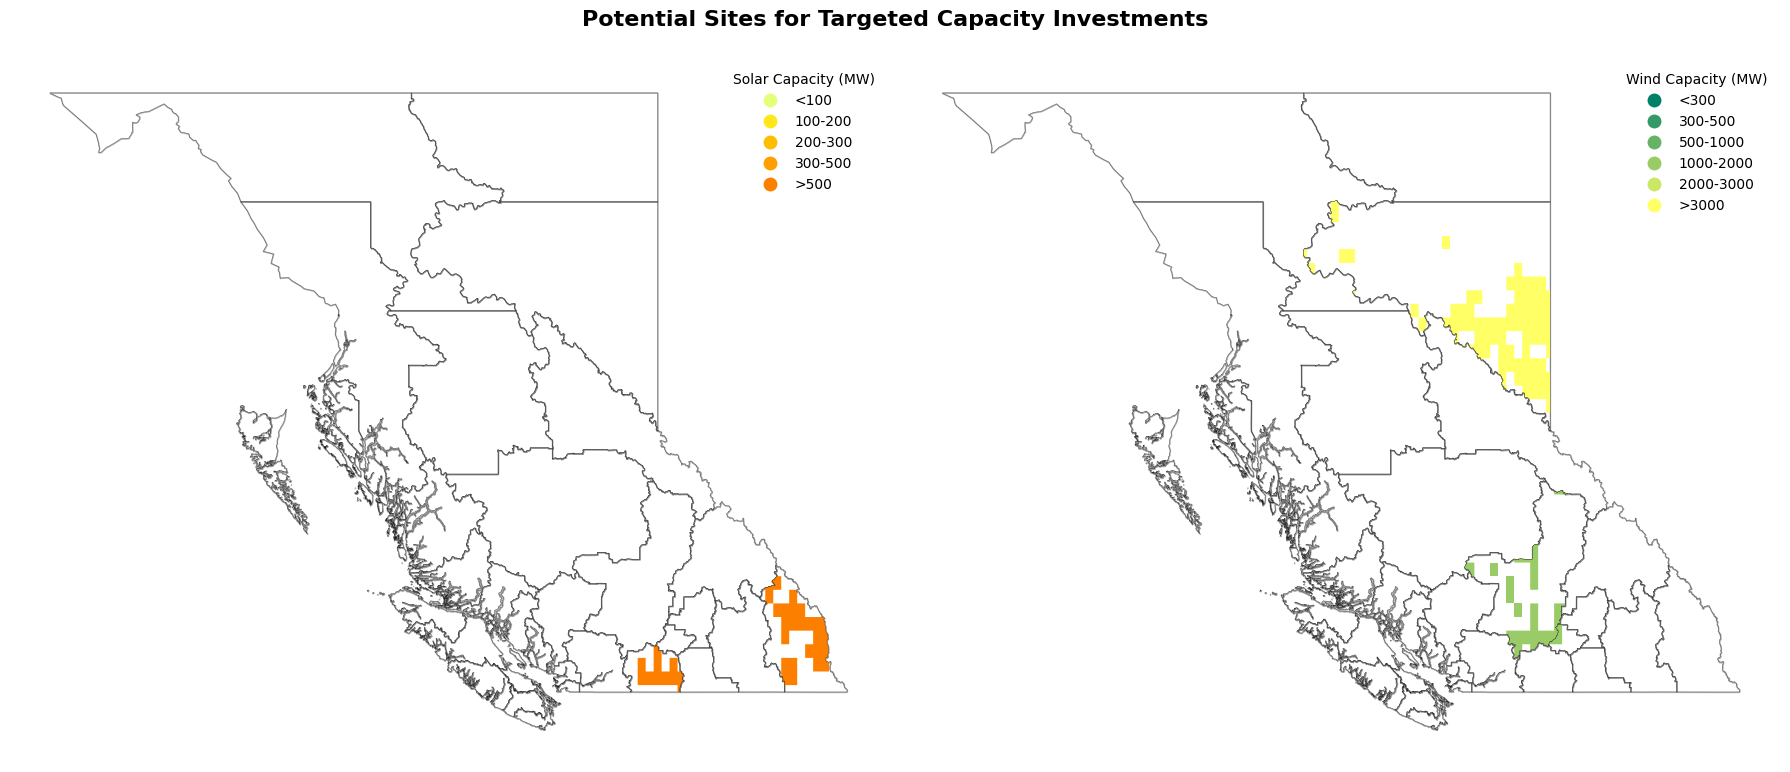

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset=1
# Ensure 'Region' is in the columns for both boundary and cells
if 'Region' not in boundary.columns:
    boundary = boundary.reset_index(inplace=True)

# Assign a number to each region
boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()

# Show the side-by-side plot

# plt.savefig('solar_wind_capacity_map.png',dpi=300)
plt.show()